In [2]:
# Step 1: Load and preprocess the data
!pip install torchinfo
from torchinfo import summary
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
# Load the BRFSS dataset
file_path = "/content/Behavioral_Risk_Factor_Surveillance_System__BRFSS__Prevalence_Data__2011_to_present__20250421.csv"  # Update this path if needed
df = pd.read_csv(file_path)


In [3]:
# Filter for relevant entries
depression_df = df[
    (df['Topic'] == 'Depression') &
    (df['Question'].str.contains("Ever told you that you have a form of depression?", case=False)) &
    (df['Response'] == 'Yes')
]

# Select necessary columns and drop NAs
depression_df = depression_df[['Year', 'Locationabbr', 'Break_Out', 'Break_Out_Category', 'Sample_Size', 'Data_value']].dropna()

# Combine demographic category and group for more granular features
depression_df['Demographic'] = depression_df['Break_Out_Category'] + " - " + depression_df['Break_Out']

# Pivot and average by group
pivot_df = depression_df.pivot_table(
    index=['Year', 'Locationabbr', 'Demographic'],
    values=['Data_value', 'Sample_Size'],
    aggfunc='mean'
).reset_index()

# Extract features for encoding
pivot_df['Year'] = pivot_df['Year'].astype(str)
features = pivot_df[['Year', 'Locationabbr', 'Demographic']]
target = pivot_df['Data_value'].values
sample_size = pivot_df['Sample_Size'].values.reshape(-1, 1)





In [4]:
# One-hot encode categorical features
!pip install --upgrade scikit-learn
from sklearn.preprocessing import OneHotEncoder # this line was present in the original code. Including it here for clarity
encoder = OneHotEncoder(sparse_output=False) # Use sparse_output instead of sparse
X_encoded = encoder.fit_transform(features)

# Combine encoded features with sample size
X_combined = np.hstack((X_encoded, sample_size))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Split the data into train and test sets (after scaling)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.2, random_state=42
)  # Adjust test_size and random_state as needed

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [7]:
# Dataset and loaders
dataset = TensorDataset(X_train_tensor, y_train_tensor) # Updated to use training data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define improved model architecture
class ImprovedDepressionPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDepressionPredictor, self).__init__()
        self.network = nn.Sequential(
          nn.Linear(input_dim, 512),
          nn.ReLU(),
          nn.BatchNorm1d(512),
          nn.Dropout(0.3),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.BatchNorm1d(256),
          nn.Dropout(0.3),
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model using the correct class name: ImprovedDepressionPredictor
model = ImprovedDepressionPredictor(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Optional: View model structure (include screenshot in your paper)
summary(model, input_size=(64, X_train.shape[1]))

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedDepressionPredictor              [64, 1]                   --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 512]                 51,200
│    └─ReLU: 2-2                         [64, 512]                 --
│    └─BatchNorm1d: 2-3                  [64, 512]                 1,024
│    └─Dropout: 2-4                      [64, 512]                 --
│    └─Linear: 2-5                       [64, 256]                 131,328
│    └─ReLU: 2-6                         [64, 256]                 --
│    └─BatchNorm1d: 2-7                  [64, 256]                 512
│    └─Dropout: 2-8                      [64, 256]                 --
│    └─Linear: 2-9                       [64, 64]                  16,448
│    └─ReLU: 2-10                        [64, 64]                  --
│    └─Linear: 2-11                      [64, 1]                   6

In [8]:
train_losses = []
val_losses = []
epochs = 150

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # --- Move data to device before forward pass ---
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
      # --- Move validation data to device ---
      val_preds = model(X_test_tensor.to(device))
      val_loss = criterion(val_preds, y_test_tensor.to(device)).item()
      val_losses.append(val_loss)
      scheduler.step(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")




Epoch 0 | Train Loss: 161.6548 | Val Loss: 16.9912
Epoch 10 | Train Loss: 8.1556 | Val Loss: 7.4779
Epoch 20 | Train Loss: 6.1821 | Val Loss: 6.8387
Epoch 30 | Train Loss: 5.3600 | Val Loss: 6.7283
Epoch 40 | Train Loss: 4.6889 | Val Loss: 6.7814
Epoch 50 | Train Loss: 4.4717 | Val Loss: 6.7041
Epoch 60 | Train Loss: 4.4888 | Val Loss: 6.7089
Epoch 70 | Train Loss: 4.2264 | Val Loss: 6.6705
Epoch 80 | Train Loss: 4.2669 | Val Loss: 6.6676
Epoch 90 | Train Loss: 4.2897 | Val Loss: 6.6823
Epoch 100 | Train Loss: 4.3480 | Val Loss: 6.6524
Epoch 110 | Train Loss: 4.2268 | Val Loss: 6.6268
Epoch 120 | Train Loss: 4.2958 | Val Loss: 6.6696
Epoch 130 | Train Loss: 4.2863 | Val Loss: 6.6431
Epoch 140 | Train Loss: 4.1726 | Val Loss: 6.6778


In [9]:
# --- [6] Final Evaluation ---
val_preds_np = val_preds.detach().cpu().numpy().flatten() # Detach from computation graph and move to CPU
y_test_np = y_test_tensor.detach().cpu().numpy().flatten() # Detach from computation graph and move to CPU before converting to NumPy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


rmse = np.sqrt(mean_squared_error(y_test_np, val_preds_np))
mae = mean_absolute_error(y_test_np, val_preds_np)
r2 = r2_score(y_test_np, val_preds_np)
adj_r2 = 1 - (1 - r2) * ((len(y_test_np) - 1) / (len(y_test_np) - X_test.shape[1] - 1))

print(f"\n🔍 Final Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")




# -----------------------------
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

print("Random Forest - RMSE:", round(rf_rmse, 2),
      "| MAE:", round(rf_mae, 2),
      "| R²:", round(rf_r2, 3))

# -----------------------------
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)

print("Linear Regression - RMSE:", round(lr_rmse, 2),
      "| MAE:", round(lr_mae, 2),
      "| R²:", round(lr_r2, 3))



🔍 Final Evaluation:
RMSE: 2.58
MAE: 1.70
R²: 0.855
Random Forest - RMSE: 2.99 | MAE: 2.1 | R²: 0.805
Linear Regression - RMSE: 3.4 | MAE: 2.47 | R²: 0.747


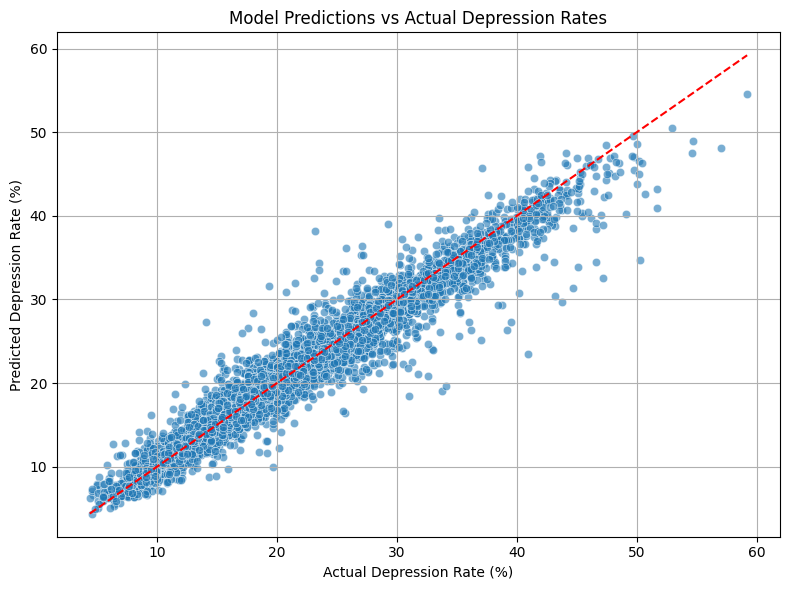

In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
model.eval()
with torch.no_grad():
    # Move X_train_tensor to the same device as the model
    predictions = model(X_train_tensor.to(device)).cpu().numpy().flatten()
    actuals = y_train_tensor.cpu().numpy().flatten()           # Using y_train_tensor for visualization

# Scatter plot of predicted vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals, y=predictions, alpha=0.6)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel("Actual Depression Rate (%)")
plt.ylabel("Predicted Depression Rate (%)")
plt.title("Model Predictions vs Actual Depression Rates")
plt.grid(True)
plt.tight_layout()
plt.show()


,Year,Locationabbr,Demographic,Predicted_Depression
13879,2022,NH,"Household Income - Less than $15,000",54.614578
13658,2022,ME,"Household Income - Less than $15,000",50.849384
7783,2017,NH,"Household Income - Less than $15,000",50.456173
7578,2017,ME,"Household Income - Less than $15,000",49.547905
13558,2022,KY,"Household Income - Less than $15,000",48.909492
14948,2023,ME,"Household Income - Less than $15,000",48.625797
8778,2018,ME,"Household Income - Less than $15,000",48.514793
3054,2013,NH,"Race/Ethnicity - Multiracial, non-Hispanic",48.082405
13001,2021,VT,"Household Income - Less than $15,000",47.473637
12578,2021,NH,"Household Income - Less than $15,000",47.457165


,Locationabbr,Predicted_Depression,Data_value,Avg_Prediction_Error
32,NJ,14.626719,14.498188,0.128530
7,DC,19.745049,19.639655,0.105393
15,IL,17.522678,17.434471,0.088207
28,NC,20.897209,20.825329,0.071880
30,NE,18.625294,18.555082,0.070212
34,NV,17.851147,17.782818,0.068329
21,MD,17.104269,17.046835,0.057434
43,SD,18.527504,18.493727,0.033777
29,ND,20.770521,20.758099,0.012423
49,VA,18.402439,18.392384,0.010055


,Year,Predicted_Depression,Data_value,Avg_Prediction_Error
0,2011,18.363224,18.494521,-0.131297
1,2012,18.674507,18.799661,-0.125154
2,2013,19.573215,19.773707,-0.200491
3,2014,19.714695,19.757107,-0.042412
4,2015,19.892426,20.051024,-0.158598
5,2016,19.172598,19.272420,-0.099822
6,2017,21.118349,21.304090,-0.185741
7,2018,20.569574,20.764417,-0.194842
8,2019,20.877590,21.078498,-0.200908
9,2020,20.728556,20.882047,-0.153491


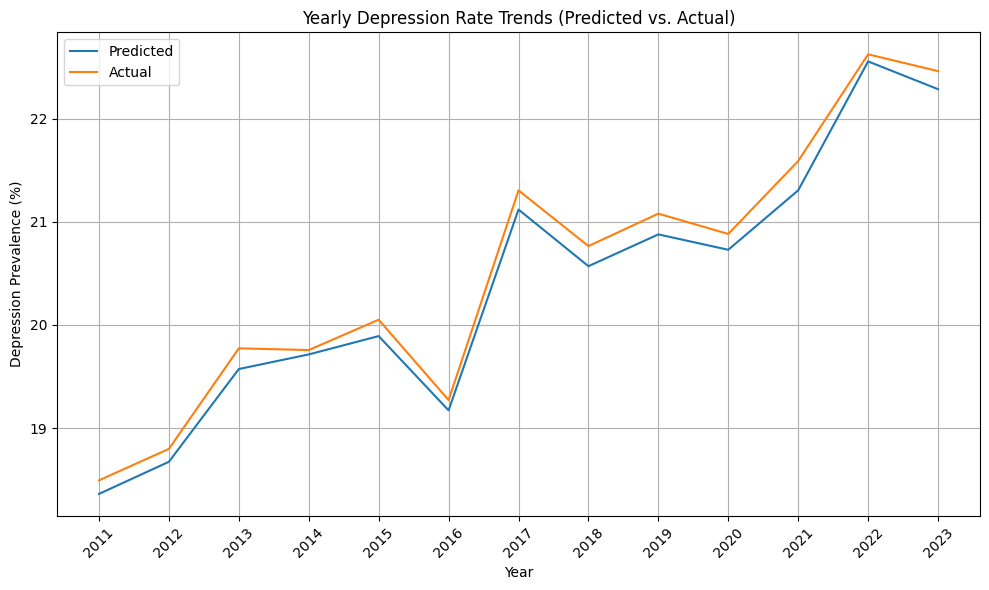

In [11]:
# --- Add predictions to full dataset ---
model.eval()
with torch.no_grad():
    # Move X_scaled to the same device as the model
    all_preds = model(torch.tensor(X_scaled, dtype=torch.float32, device=device)).cpu().numpy().flatten()  # Add device=device here


# Add predictions and errors to pivot_df
pivot_df['Predicted_Depression'] = all_preds
pivot_df['Prediction_Error'] = pivot_df['Predicted_Depression'] - pivot_df['Data_value']

# ---- A. Top 10 Most At-Risk Demographic Groups ----
top_at_risk_groups = pivot_df.sort_values(by='Predicted_Depression', ascending=False).head(10)
display(top_at_risk_groups[['Year', 'Locationabbr', 'Demographic', 'Predicted_Depression']])

# ---- B. State-Level Prediction Performance ----
state_perf = pivot_df.groupby('Locationabbr')[['Predicted_Depression', 'Data_value']].mean().reset_index()
state_perf['Avg_Prediction_Error'] = state_perf['Predicted_Depression'] - state_perf['Data_value']
state_perf = state_perf.sort_values('Avg_Prediction_Error', ascending=False)
display(state_perf)

# ---- C. Year-Level Prediction Trends ----
year_trends = pivot_df.groupby('Year')[['Predicted_Depression', 'Data_value']].mean().reset_index()
year_trends['Avg_Prediction_Error'] = year_trends['Predicted_Depression'] - year_trends['Data_value']
display(year_trends)

# Optional: Visualize year trend
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(year_trends['Year'], year_trends['Predicted_Depression'], label='Predicted')
plt.plot(year_trends['Year'], year_trends['Data_value'], label='Actual')
plt.title("Yearly Depression Rate Trends (Predicted vs. Actual)")
plt.xlabel("Year")
plt.ylabel("Depression Prevalence (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
